In [1]:
from model_phantom_DB import *
from linares_plot import * 
import itertools

%matplotlib inline
%config InlineBackend.figure_format = 'png' ## 'svg'

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import pandas as pd

In [2]:
### en vez de cargar todos los datos, solo cargar las y
### las X cargo solo los datos de la neurona 0

# simulations_ON_rE = 'C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\simuls_on_class_re.xlsx'
# simulations_ON_targets = 'C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\simuls_on_class_targets.xlsx'

# simulations_OFF_rE = 'C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\simuls_off_class_re.xlsx'
# simulations_OFF_targets = 'C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\simuls_off_class_targets.xlsx'

# y_off_all=pd.read_excel(simulations_OFF_targets).values
# X_off_all= pd.read_excel(simulations_OFF_rE).values

# y_on_all=pd.read_excel(simulations_ON_targets).values
# X_on_all= pd.read_excel(simulations_ON_rE).values

In [3]:
##guardar los datos de la neurona 0, 1, y 256 
# simpl_X_on_all= pd.DataFrame(X_on_all[:, 0])
# simpl_X_on_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron0_simuls_on_class_re.xlsx')
# simpl_X_off_all= pd.DataFrame(X_off_all[:, 0])
# simpl_X_off_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron0_simuls_off_class_re.xlsx')


# simpl_X_on_all= pd.DataFrame(X_on_all[:, 1])
# simpl_X_on_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron1_simuls_on_class_re.xlsx')
# simpl_X_off_all= pd.DataFrame(X_off_all[:, 1])
# simpl_X_off_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron1_simuls_off_class_re.xlsx')


# simpl_X_on_all= pd.DataFrame(X_on_all[:, int(512/2)])
# simpl_X_on_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron256_simuls_on_class_re.xlsx')
# simpl_X_off_all= pd.DataFrame(X_off_all[:, int(512/2)])
# simpl_X_off_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron256_simuls_off_class_re.xlsx')

In [4]:
simpl_X_on_all = pd.read_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron256_simuls_on_class_re.xlsx')
simpl_X_off_all = pd.read_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron256_simuls_on_class_re.xlsx')


simulations_ON_targets = 'C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\simuls_on_class_targets.xlsx'
simulations_OFF_targets = 'C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\simuls_off_class_targets.xlsx'

y_off_all=pd.read_excel(simulations_OFF_targets).values
y_on_all=pd.read_excel(simulations_ON_targets).values


In [ ]:
Window = 30
n_neuron=180 
inic=n_neuron - int(Window/2)
fin=n_neuron + int(Window/2)

wind=1

reps_=50

## get y_off
y_off=y_off_all
bool_int = (y_off>=inic) & (y_off<=fin)
y_off = y_off[bool_int]
y_off = np.reshape(y_off, (len(y_off),1))
y_off= label_binarize(y_off, classes=np.arange(inic, fin, wind)) #matrix (1,0,0,...,0)
n_classes = y_off.shape[1]

## get X_off
bool_reshaped = np.reshape(bool_int, (len(bool_int)))
#### X_off = X_off_all[bool_reshaped,n_neuron]
X_off = simpl_X_off_all[bool_reshaped]

X_off =np.reshape(X_off, (len(X_off),1))

########################################################################

## get y_on
y_on=y_on_all
bool_int =  (y_on>=inic) & (y_on<=fin)
y_on = y_on[bool_int]
y_on = np.reshape(y_on, (len(y_on),1))
y_on= label_binarize(y_on, classes=np.arange(inic, fin, wind)) #matrix (1,0,0,...,0)
n_classes = y_on.shape[1]

## get X_off
bool_reshaped = np.reshape(bool_int, (len(bool_int)))
#### X_on = X_on_all[bool_reshaped,n_neuron]
X_on = simpl_X_on_all[bool_reshaped]

X_on =np.reshape(X_on, (len(X_on),1))


##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000))

fpr_mean_off = []
tpr_mean_off = []
roc_mean_off = []

fpr_mean_on = []
tpr_mean_on = []
roc_mean_on = []



for stimulation in ['ON', 'OFF']:
    if stimulation=='ON':
        X=X_on
        y=y_on
    elif stimulation=='OFF':
        X=X_off
        y=y_off
    
    ###
    ### many train and test to validate the measure
    for rep in range(reps_):
        print(rep)
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        # score
        #fitted = classifier.fit(X_train, y_train)
        #y_score = fitted.decision_function(X_test)
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)

        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        if stimulation=='ON':
            fpr_mean_on.append(fpr["macro"])
            tpr_mean_on.append(tpr["macro"])
            roc_mean_on.append(roc_auc["macro"])
        elif stimulation=='OFF':
            fpr_mean_off.append(fpr["macro"])
            tpr_mean_off.append(tpr["macro"])
            roc_mean_off.append(roc_auc["macro"])


    
####

0
1
2
3
4
5


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


6


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


7


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


8
9
10
11
12


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


13
14
15
16
17
18
19
20
21
22


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


23


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


24
25
26
27
28
29
30
31


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


32


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


33
34
35


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


36


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


37
38
39
40
41
42
43


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


44
45
46
47


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


48
49


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0
1
2


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


3
4
5


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


6
7


In [ ]:
np.shape(fpr_mean_off)


In [ ]:
plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



fpr_mean_on = np.concatenate(fpr_mean_on)
tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC, win: ' +str(Window))
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


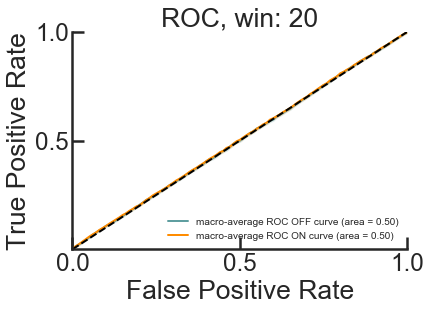

In [49]:
plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



fpr_mean_on = np.concatenate(fpr_mean_on)
tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC, win: ' +str(Window))
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')